# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [16]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

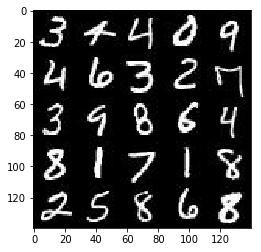

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

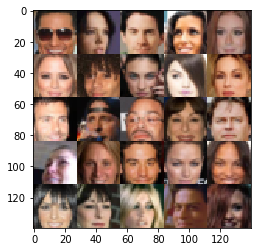

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [20]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="real_input")
    z_input = tf.placeholder(tf.float32, shape=(None,z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return real_input , z_input ,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [73]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    with tf.variable_scope("discriminator",reuse=reuse) :
        # Input layer is 28x28x3
        ip_layer = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        ip_leaky_relu = tf.maximum(alpha * ip_layer, ip_layer)
        # 14x14x64
        
        conv_layer_1 = tf.layers.conv2d(ip_leaky_relu, 128, 5, strides=2, padding='same')
        bn_layer_1 = tf.layers.batch_normalization(conv_layer_1, training=True)
        conv_layer_1_leaky_relu = tf.maximum(alpha * bn_layer_1, bn_layer_1)
        # 7x7x128
        
        conv_layer_2 = tf.layers.conv2d(conv_layer_1_leaky_relu, 256, 5, strides=2, padding='same')
        bn_layer_2 = tf.layers.batch_normalization(conv_layer_2, training=True)
        conv_layer_2_leaky_relu = tf.maximum(alpha * bn_layer_2, bn_layer_2)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(conv_layer_2_leaky_relu, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [67]:
def generator(z, out_channel_dim,is_train=True,beta1=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope("generator",reuse=not is_train) :
        # First fully connected layer
        ip_layer = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        ip_layer = tf.reshape(ip_layer, (-1, 7, 7, 512))
        ip_bn_layer = tf.layers.batch_normalization(ip_layer, training=is_train)
        ip_leaky_relu = tf.maximum(alpha * ip_bn_layer, ip_bn_layer)
        # 7x7x512 now
        
        conv_layer_1 = tf.layers.conv2d_transpose(ip_leaky_relu, 256, 5, strides=1, padding='same')
        bn_layer_1 = tf.layers.batch_normalization(conv_layer_1, training=is_train)
        conv_layer_1_leaky_relu = tf.maximum(alpha * bn_layer_1, bn_layer_1)
        # 7x7x256 now
        
        conv_layer_2 = tf.layers.conv2d_transpose(conv_layer_1_leaky_relu, 128, 5, strides=2, padding='same')
        bn_layer_2 = tf.layers.batch_normalization(conv_layer_2, training=is_train)
        conv_layer_2_leaky_relu = tf.maximum(alpha * bn_layer_2, bn_layer_2)
        # 14x14x128 now
        
        conv_layer_3 = tf.layers.conv2d_transpose(conv_layer_2_leaky_relu, 64, 5, strides=2, padding='same')
        bn_layer_3 = tf.layers.batch_normalization(conv_layer_3, training=is_train)
        conv_layer_3_leaky_relu = tf.maximum(alpha * bn_layer_3, bn_layer_3)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(conv_layer_3_leaky_relu, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [68]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
        
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [69]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [70]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [71]:
from time import time
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # set Tensorboard logging dir
    logging_path = "logs/{}".format(time())
    
    # parse input parameters
    width, height, channel = data_shape[1], data_shape[2], data_shape[3]
    
    # get model tensors
    input_real, input_z, learn_rate = model_inputs(width, height, channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    # create model saver object
    saver = tf.train.Saver()
    
    # create a summary for our cost and accuracy
    tf.summary.scalar("discriminator_loss", d_loss)
    tf.summary.scalar("generator_loss", g_loss)
    
    # merge all summaries into a single "operation" which we can execute in a session 
    summary_op = tf.summary.merge_all()
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # create log writer object
        writer = tf.summary.FileWriter(logging_path,sess.graph,filename_suffix="log",flush_secs=2)
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
                # Run summary generation
                summary = sess.run(summary_op, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
                # write log
                writer.add_summary(summary,steps)
                
                if steps % 100 == 0:
                    # print the losses every 100 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}..., step {}".format(epoch_i+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, channel, data_image_mode)

        saver.save(sess, './generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2..., step 100 Discriminator Loss: 2.1506... Generator Loss: 0.3741


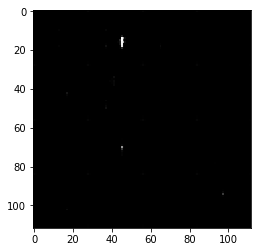

Epoch 1/2..., step 200 Discriminator Loss: 0.4195... Generator Loss: 7.6449


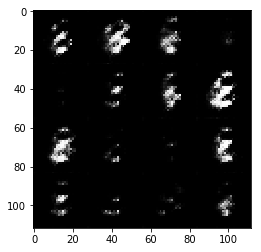

Epoch 1/2..., step 300 Discriminator Loss: 2.8040... Generator Loss: 6.3086


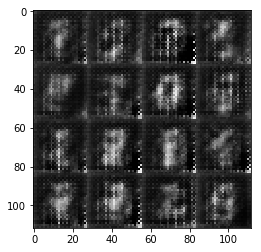

Epoch 1/2..., step 400 Discriminator Loss: 0.8511... Generator Loss: 1.1753


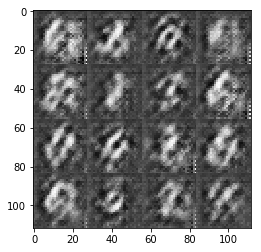

Epoch 1/2..., step 500 Discriminator Loss: 3.5983... Generator Loss: 0.0439


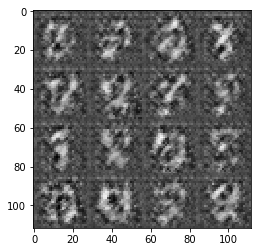

Epoch 1/2..., step 600 Discriminator Loss: 1.5937... Generator Loss: 3.0237


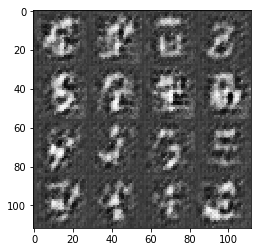

Epoch 1/2..., step 700 Discriminator Loss: 0.6202... Generator Loss: 1.4820


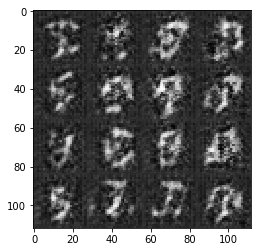

Epoch 1/2..., step 800 Discriminator Loss: 0.5233... Generator Loss: 2.4080


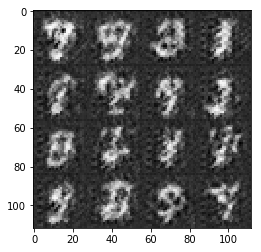

Epoch 1/2..., step 900 Discriminator Loss: 0.8644... Generator Loss: 1.2183


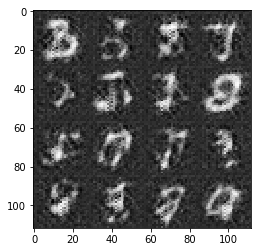

Epoch 1/2..., step 1000 Discriminator Loss: 0.8933... Generator Loss: 4.7415


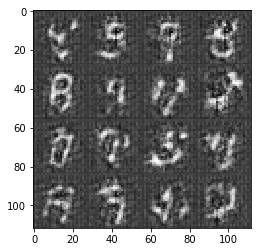

Epoch 1/2..., step 1100 Discriminator Loss: 0.6057... Generator Loss: 1.6136


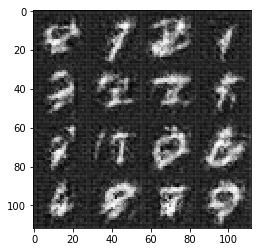

Epoch 1/2..., step 1200 Discriminator Loss: 0.3502... Generator Loss: 4.2451


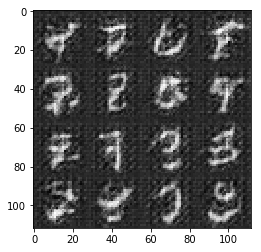

Epoch 1/2..., step 1300 Discriminator Loss: 0.5024... Generator Loss: 5.1196


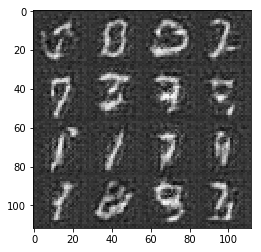

Epoch 1/2..., step 1400 Discriminator Loss: 0.5380... Generator Loss: 2.2608


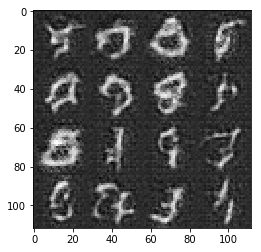

Epoch 1/2..., step 1500 Discriminator Loss: 0.4122... Generator Loss: 3.5584


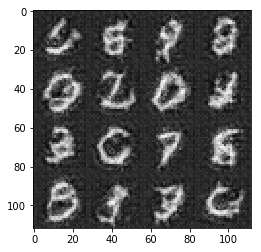

Epoch 1/2..., step 1600 Discriminator Loss: 0.6794... Generator Loss: 1.6752


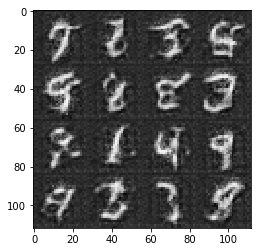

Epoch 1/2..., step 1700 Discriminator Loss: 0.8736... Generator Loss: 5.3528


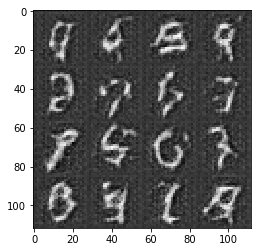

Epoch 1/2..., step 1800 Discriminator Loss: 0.5925... Generator Loss: 1.9449


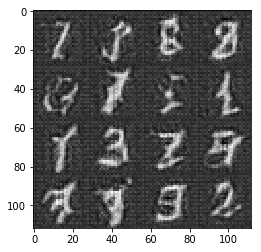

Epoch 1/2..., step 1900 Discriminator Loss: 0.4231... Generator Loss: 2.8490


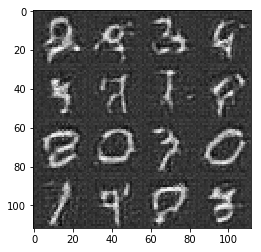

Epoch 1/2..., step 2000 Discriminator Loss: 1.1038... Generator Loss: 0.7013


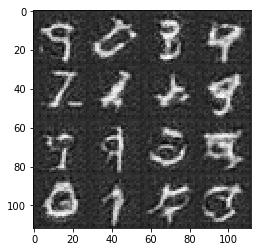

Epoch 1/2..., step 2100 Discriminator Loss: 0.8799... Generator Loss: 2.8461


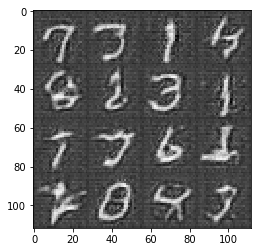

Epoch 1/2..., step 2200 Discriminator Loss: 1.0159... Generator Loss: 0.8622


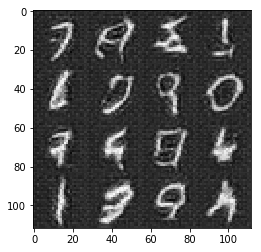

Epoch 1/2..., step 2300 Discriminator Loss: 0.7872... Generator Loss: 1.2272


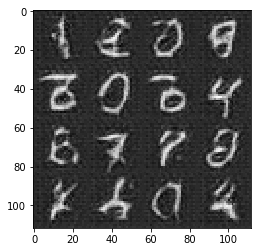

Epoch 1/2..., step 2400 Discriminator Loss: 0.9275... Generator Loss: 4.2283


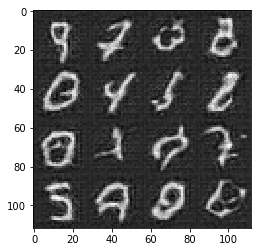

Epoch 1/2..., step 2500 Discriminator Loss: 1.0922... Generator Loss: 0.7599


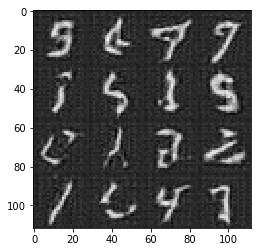

Epoch 1/2..., step 2600 Discriminator Loss: 0.5624... Generator Loss: 1.8684


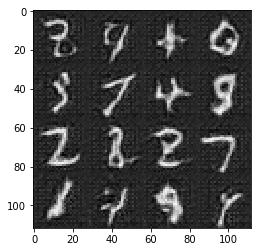

Epoch 1/2..., step 2700 Discriminator Loss: 0.6405... Generator Loss: 2.5183


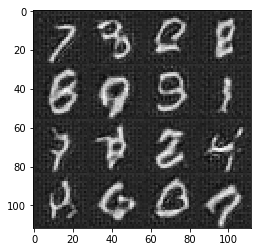

Epoch 1/2..., step 2800 Discriminator Loss: 0.3697... Generator Loss: 4.1214


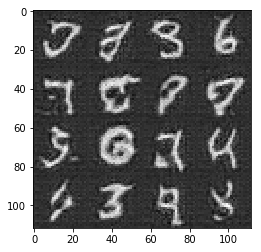

Epoch 1/2..., step 2900 Discriminator Loss: 1.7353... Generator Loss: 0.4765


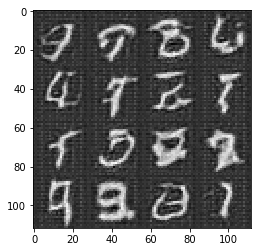

Epoch 1/2..., step 3000 Discriminator Loss: 0.4591... Generator Loss: 2.4191


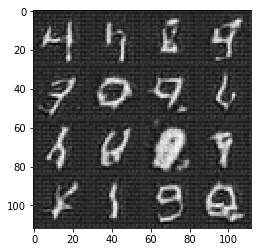

Epoch 1/2..., step 3100 Discriminator Loss: 2.0147... Generator Loss: 3.8882


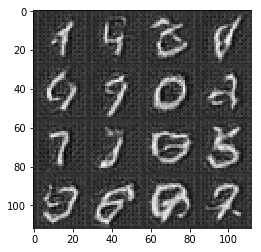

Epoch 1/2..., step 3200 Discriminator Loss: 0.6603... Generator Loss: 1.5283


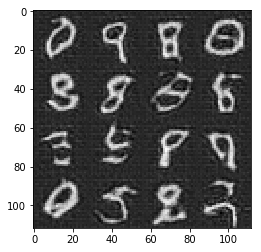

Epoch 1/2..., step 3300 Discriminator Loss: 0.7675... Generator Loss: 1.5346


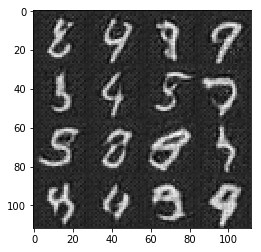

Epoch 1/2..., step 3400 Discriminator Loss: 1.1304... Generator Loss: 0.6821


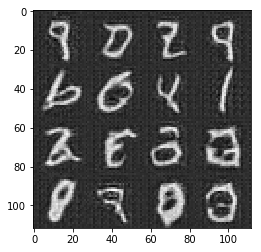

Epoch 1/2..., step 3500 Discriminator Loss: 1.8422... Generator Loss: 0.3309


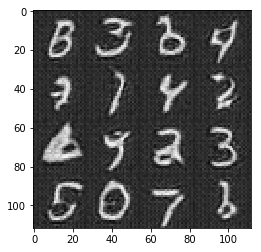

Epoch 1/2..., step 3600 Discriminator Loss: 0.4119... Generator Loss: 3.5160


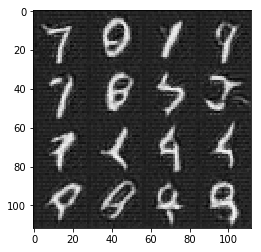

Epoch 1/2..., step 3700 Discriminator Loss: 0.6727... Generator Loss: 1.5027


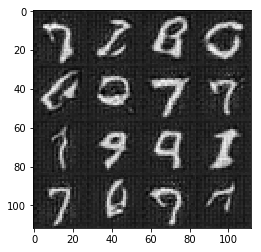

Epoch 1/2..., step 3800 Discriminator Loss: 0.7322... Generator Loss: 1.3473


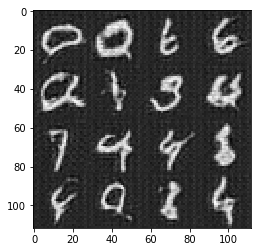

Epoch 1/2..., step 3900 Discriminator Loss: 0.4813... Generator Loss: 2.5619


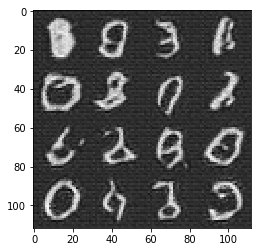

Epoch 1/2..., step 4000 Discriminator Loss: 2.7020... Generator Loss: 2.3625


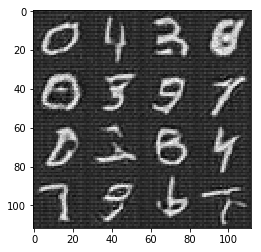

Epoch 1/2..., step 4100 Discriminator Loss: 0.7691... Generator Loss: 1.4289


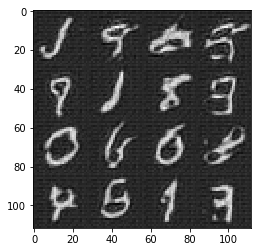

Epoch 1/2..., step 4200 Discriminator Loss: 1.3105... Generator Loss: 0.6379


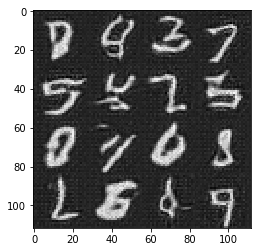

Epoch 1/2..., step 4300 Discriminator Loss: 0.5754... Generator Loss: 1.8808


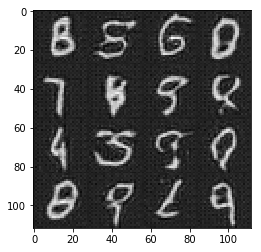

Epoch 1/2..., step 4400 Discriminator Loss: 0.6222... Generator Loss: 1.7636


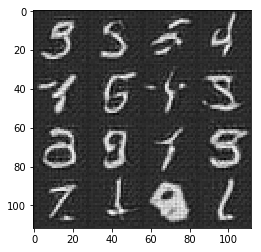

Epoch 1/2..., step 4500 Discriminator Loss: 0.4869... Generator Loss: 2.2125


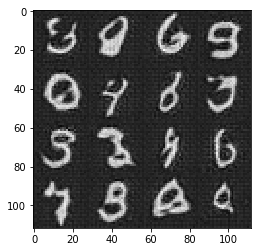

Epoch 1/2..., step 4600 Discriminator Loss: 1.6223... Generator Loss: 0.3648


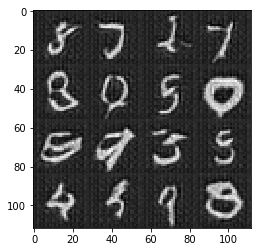

Epoch 1/2..., step 4700 Discriminator Loss: 1.7034... Generator Loss: 0.3896


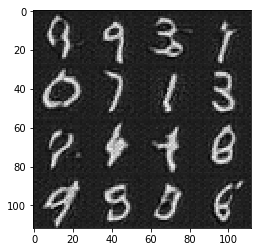

Epoch 1/2..., step 4800 Discriminator Loss: 1.0504... Generator Loss: 0.7874


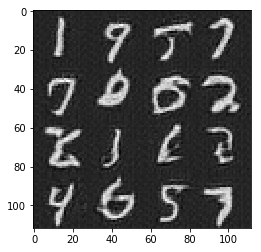

Epoch 1/2..., step 4900 Discriminator Loss: 0.4641... Generator Loss: 2.5469


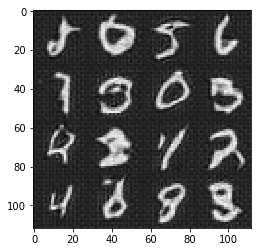

Epoch 1/2..., step 5000 Discriminator Loss: 0.8623... Generator Loss: 1.3065


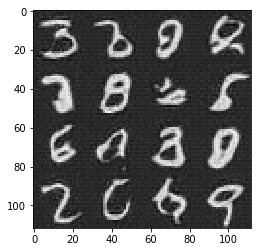

Epoch 1/2..., step 5100 Discriminator Loss: 1.4892... Generator Loss: 0.5329


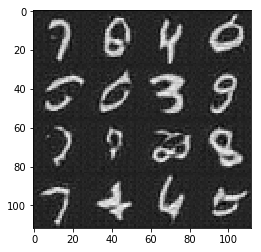

Epoch 1/2..., step 5200 Discriminator Loss: 1.2740... Generator Loss: 0.7423


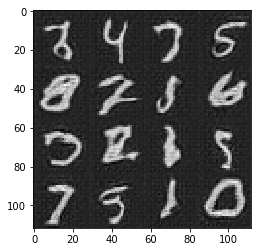

Epoch 1/2..., step 5300 Discriminator Loss: 0.3896... Generator Loss: 3.7978


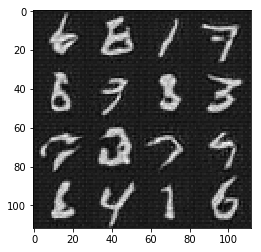

Epoch 1/2..., step 5400 Discriminator Loss: 0.7747... Generator Loss: 3.5829


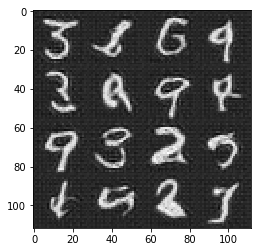

Epoch 1/2..., step 5500 Discriminator Loss: 0.6875... Generator Loss: 1.6580


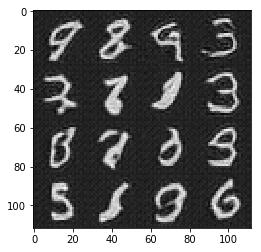

Epoch 1/2..., step 5600 Discriminator Loss: 0.7943... Generator Loss: 1.1139


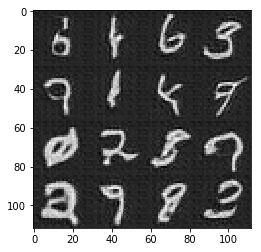

Epoch 1/2..., step 5700 Discriminator Loss: 0.5885... Generator Loss: 2.3664


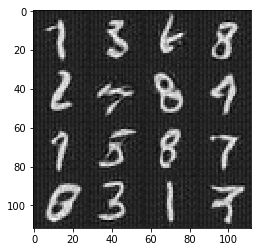

Epoch 1/2..., step 5800 Discriminator Loss: 0.7417... Generator Loss: 1.2776


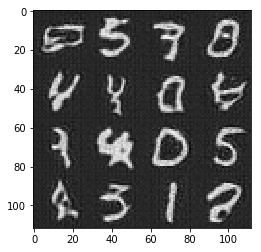

Epoch 1/2..., step 5900 Discriminator Loss: 1.2964... Generator Loss: 0.5987


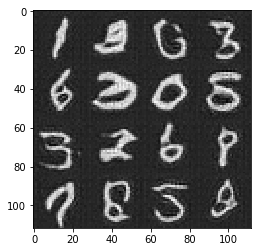

Epoch 1/2..., step 6000 Discriminator Loss: 0.5416... Generator Loss: 1.9638


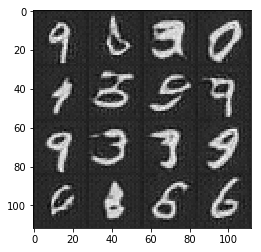

Epoch 2/2..., step 6100 Discriminator Loss: 1.2721... Generator Loss: 0.7880


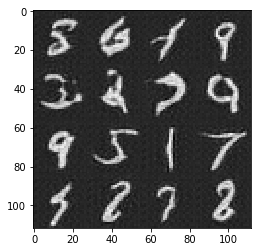

Epoch 2/2..., step 6200 Discriminator Loss: 0.5734... Generator Loss: 3.1047


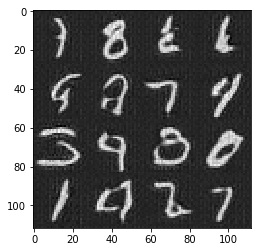

Epoch 2/2..., step 6300 Discriminator Loss: 0.6121... Generator Loss: 1.7796


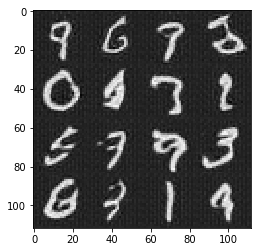

Epoch 2/2..., step 6400 Discriminator Loss: 0.7501... Generator Loss: 1.7444


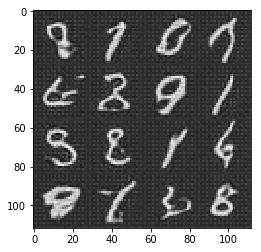

Epoch 2/2..., step 6500 Discriminator Loss: 1.2070... Generator Loss: 0.8278


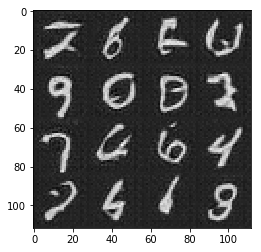

Epoch 2/2..., step 6600 Discriminator Loss: 1.9790... Generator Loss: 4.0767


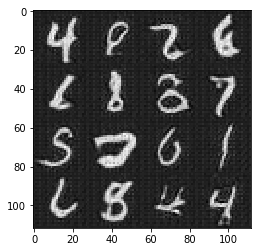

Epoch 2/2..., step 6700 Discriminator Loss: 0.9257... Generator Loss: 2.0187


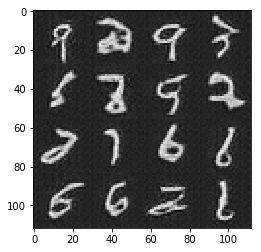

Epoch 2/2..., step 6800 Discriminator Loss: 0.4368... Generator Loss: 2.8687


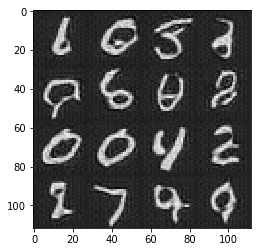

Epoch 2/2..., step 6900 Discriminator Loss: 0.8212... Generator Loss: 1.1727


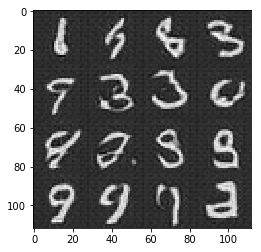

Epoch 2/2..., step 7000 Discriminator Loss: 0.4861... Generator Loss: 3.7872


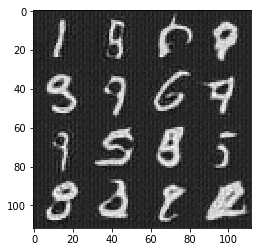

Epoch 2/2..., step 7100 Discriminator Loss: 0.5249... Generator Loss: 2.1308


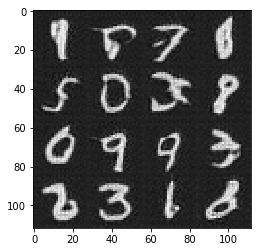

Epoch 2/2..., step 7200 Discriminator Loss: 0.4792... Generator Loss: 2.2517


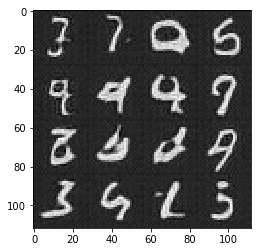

Epoch 2/2..., step 7300 Discriminator Loss: 0.8007... Generator Loss: 1.6190


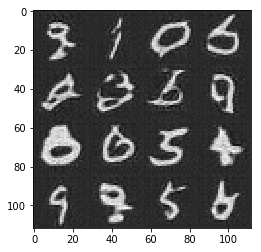

Epoch 2/2..., step 7400 Discriminator Loss: 1.1055... Generator Loss: 1.0872


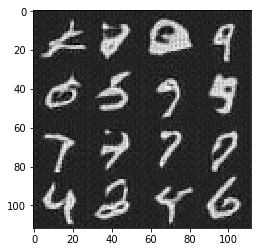

Epoch 2/2..., step 7500 Discriminator Loss: 1.0468... Generator Loss: 0.9171


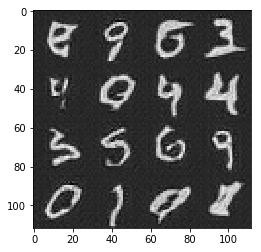

Epoch 2/2..., step 7600 Discriminator Loss: 0.5375... Generator Loss: 2.2748


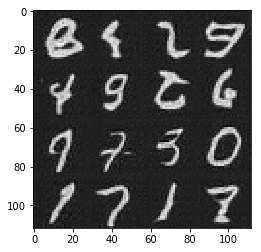

Epoch 2/2..., step 7700 Discriminator Loss: 0.8108... Generator Loss: 1.1566


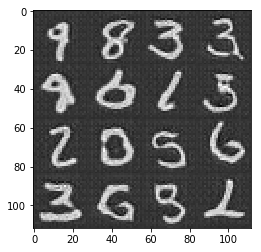

Epoch 2/2..., step 7800 Discriminator Loss: 0.8504... Generator Loss: 1.1097


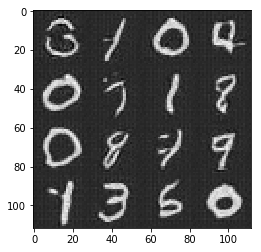

Epoch 2/2..., step 7900 Discriminator Loss: 0.4227... Generator Loss: 2.7573


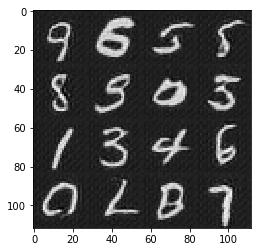

Epoch 2/2..., step 8000 Discriminator Loss: 2.7435... Generator Loss: 0.1581


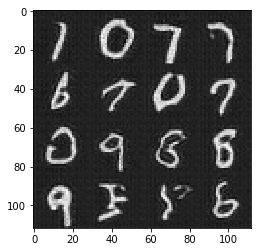

Epoch 2/2..., step 8100 Discriminator Loss: 0.8974... Generator Loss: 1.0133


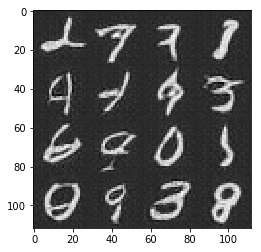

Epoch 2/2..., step 8200 Discriminator Loss: 1.2772... Generator Loss: 0.5614


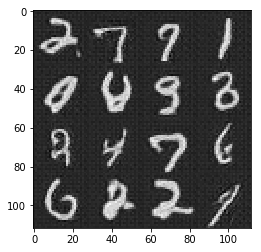

Epoch 2/2..., step 8300 Discriminator Loss: 0.4150... Generator Loss: 3.7390


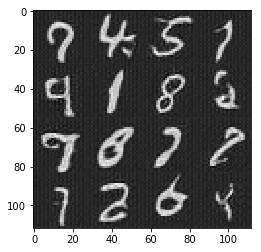

Epoch 2/2..., step 8400 Discriminator Loss: 0.7572... Generator Loss: 1.1617


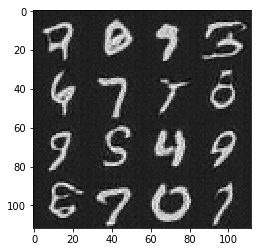

Epoch 2/2..., step 8500 Discriminator Loss: 0.6363... Generator Loss: 1.5635


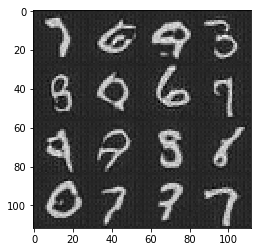

Epoch 2/2..., step 8600 Discriminator Loss: 0.4692... Generator Loss: 2.5135


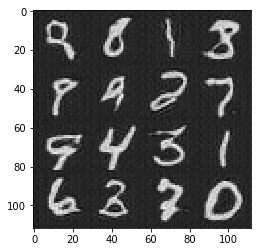

Epoch 2/2..., step 8700 Discriminator Loss: 0.6334... Generator Loss: 2.0258


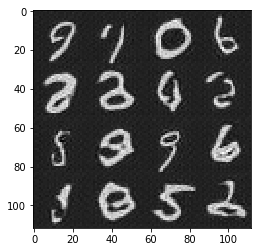

Epoch 2/2..., step 8800 Discriminator Loss: 0.8507... Generator Loss: 1.4151


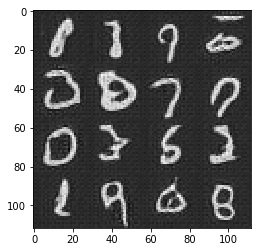

Epoch 2/2..., step 8900 Discriminator Loss: 0.7111... Generator Loss: 1.5641


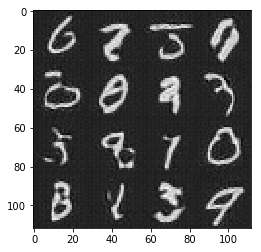

Epoch 2/2..., step 9000 Discriminator Loss: 0.7390... Generator Loss: 1.8206


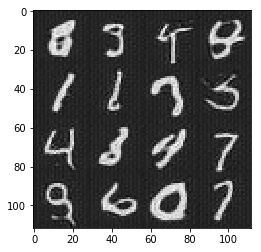

Epoch 2/2..., step 9100 Discriminator Loss: 0.8674... Generator Loss: 1.3144


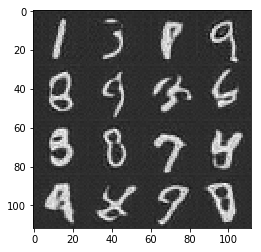

Epoch 2/2..., step 9200 Discriminator Loss: 0.8538... Generator Loss: 1.0378


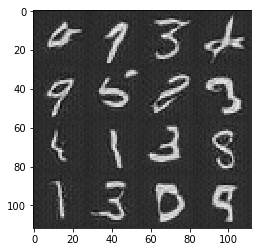

Epoch 2/2..., step 9300 Discriminator Loss: 0.6378... Generator Loss: 2.4850


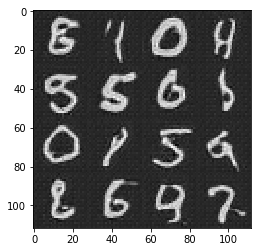

Epoch 2/2..., step 9400 Discriminator Loss: 0.9234... Generator Loss: 1.0521


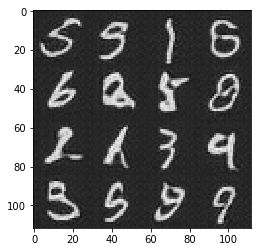

Epoch 2/2..., step 9500 Discriminator Loss: 0.5108... Generator Loss: 2.2666


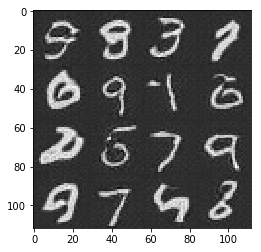

Epoch 2/2..., step 9600 Discriminator Loss: 0.4617... Generator Loss: 3.4737


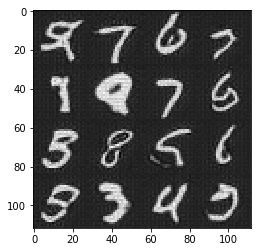

Epoch 2/2..., step 9700 Discriminator Loss: 1.5243... Generator Loss: 0.5824


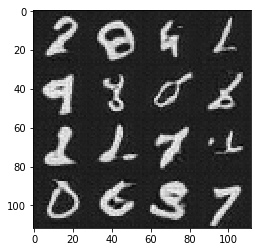

Epoch 2/2..., step 9800 Discriminator Loss: 0.7548... Generator Loss: 1.4091


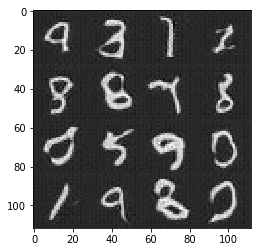

Epoch 2/2..., step 9900 Discriminator Loss: 1.0204... Generator Loss: 0.9838


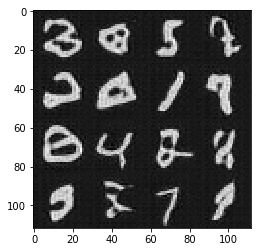

Epoch 2/2..., step 10000 Discriminator Loss: 0.7826... Generator Loss: 1.6249


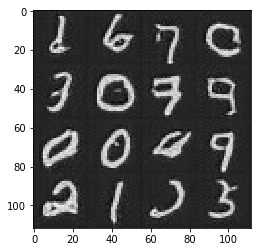

Epoch 2/2..., step 10100 Discriminator Loss: 0.6341... Generator Loss: 1.5092


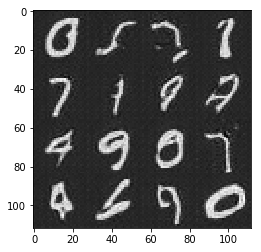

Epoch 2/2..., step 10200 Discriminator Loss: 0.6313... Generator Loss: 1.6552


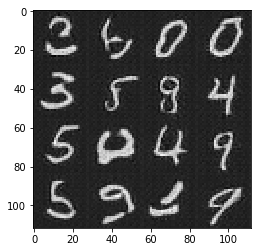

Epoch 2/2..., step 10300 Discriminator Loss: 0.5433... Generator Loss: 1.7713


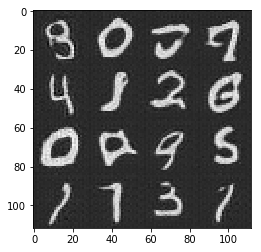

Epoch 2/2..., step 10400 Discriminator Loss: 1.7154... Generator Loss: 0.3430


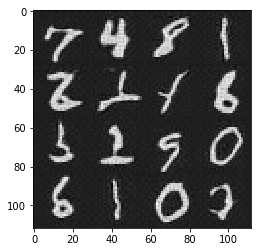

Epoch 2/2..., step 10500 Discriminator Loss: 0.3913... Generator Loss: 3.4102


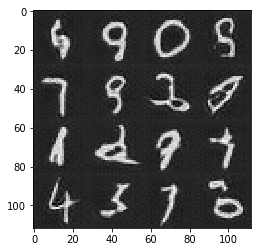

Epoch 2/2..., step 10600 Discriminator Loss: 1.0967... Generator Loss: 0.9562


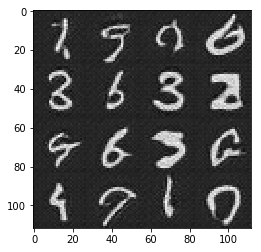

Epoch 2/2..., step 10700 Discriminator Loss: 0.4885... Generator Loss: 2.4142


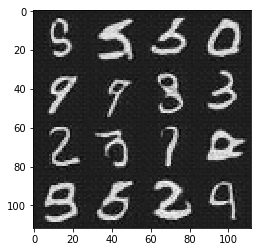

Epoch 2/2..., step 10800 Discriminator Loss: 1.3237... Generator Loss: 0.6075


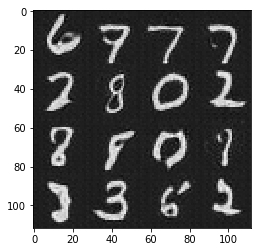

Epoch 2/2..., step 10900 Discriminator Loss: 0.9086... Generator Loss: 0.9994


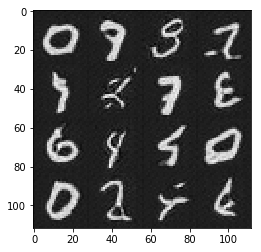

Epoch 2/2..., step 11000 Discriminator Loss: 0.5513... Generator Loss: 1.8696


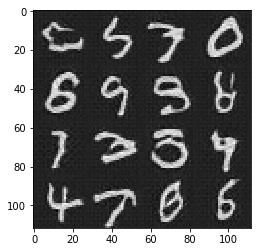

Epoch 2/2..., step 11100 Discriminator Loss: 0.8843... Generator Loss: 1.0267


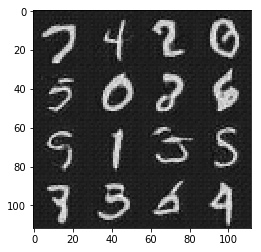

Epoch 2/2..., step 11200 Discriminator Loss: 0.7550... Generator Loss: 1.3232


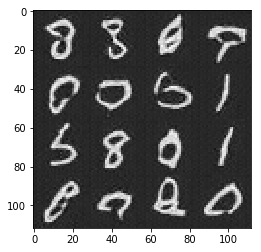

Epoch 2/2..., step 11300 Discriminator Loss: 0.7424... Generator Loss: 1.4231


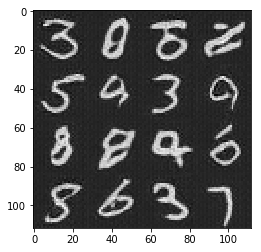

Epoch 2/2..., step 11400 Discriminator Loss: 0.5974... Generator Loss: 1.7105


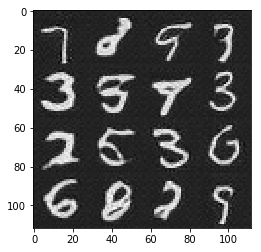

Epoch 2/2..., step 11500 Discriminator Loss: 1.3102... Generator Loss: 0.5490


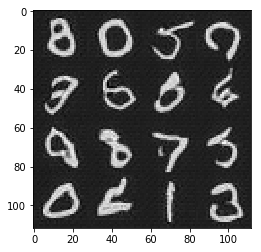

Epoch 2/2..., step 11600 Discriminator Loss: 1.4745... Generator Loss: 0.5520


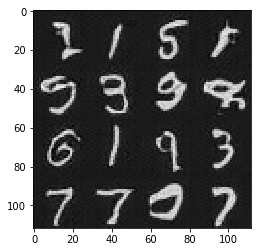

Epoch 2/2..., step 11700 Discriminator Loss: 0.4141... Generator Loss: 2.8569


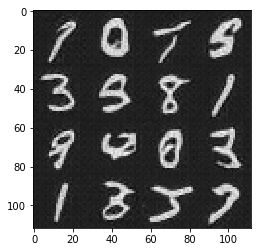

Epoch 2/2..., step 11800 Discriminator Loss: 0.8418... Generator Loss: 1.1992


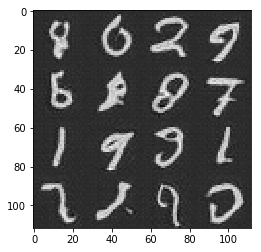

Epoch 2/2..., step 11900 Discriminator Loss: 0.9751... Generator Loss: 0.9759


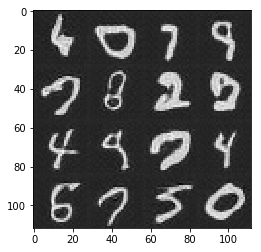

Epoch 2/2..., step 12000 Discriminator Loss: 0.4323... Generator Loss: 2.8493


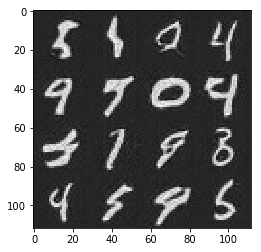

In [76]:
batch_size = 10
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2..., step 100 Discriminator Loss: 1.5427... Generator Loss: 4.0377


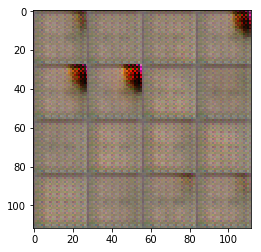

Epoch 1/2..., step 200 Discriminator Loss: 0.8330... Generator Loss: 4.0521


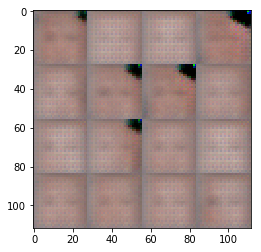

Epoch 1/2..., step 300 Discriminator Loss: 1.0016... Generator Loss: 1.3263


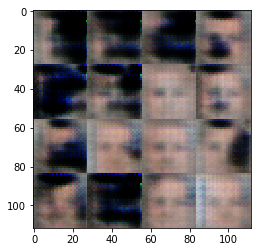

Epoch 1/2..., step 400 Discriminator Loss: 3.6439... Generator Loss: 0.1698


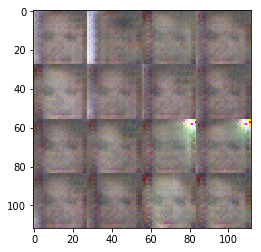

Epoch 1/2..., step 500 Discriminator Loss: 0.8808... Generator Loss: 4.6081


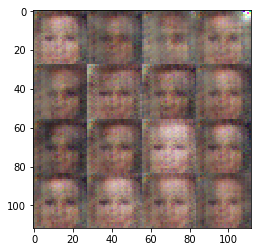

Epoch 1/2..., step 600 Discriminator Loss: 0.3413... Generator Loss: 5.3084


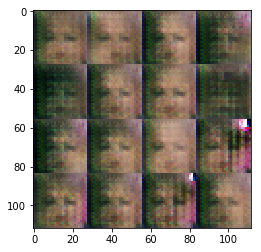

Epoch 1/2..., step 700 Discriminator Loss: 0.8331... Generator Loss: 1.7919


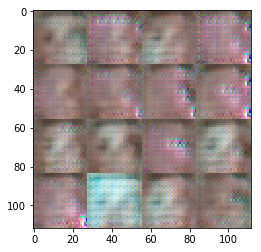

Epoch 1/2..., step 800 Discriminator Loss: 2.6548... Generator Loss: 4.6141


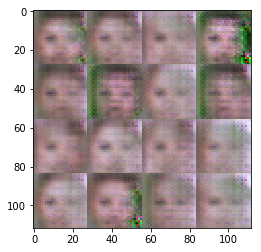

Epoch 1/2..., step 900 Discriminator Loss: 1.3607... Generator Loss: 0.6500


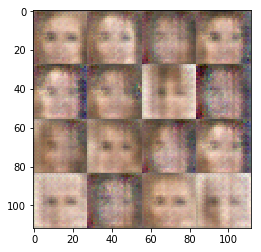

Epoch 1/2..., step 1000 Discriminator Loss: 1.1836... Generator Loss: 1.2584


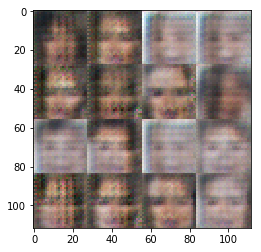

Epoch 1/2..., step 1100 Discriminator Loss: 1.0834... Generator Loss: 1.1559


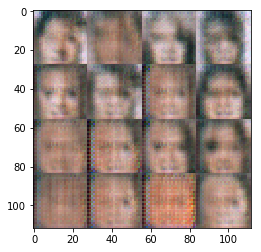

Epoch 1/2..., step 1200 Discriminator Loss: 1.1915... Generator Loss: 1.1720


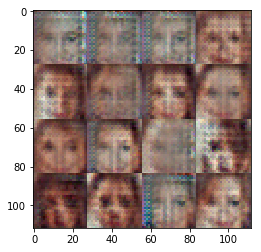

Epoch 1/2..., step 1300 Discriminator Loss: 1.0019... Generator Loss: 1.0539


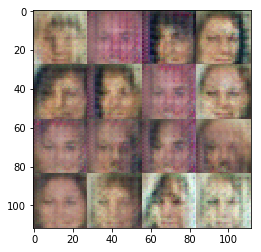

Epoch 1/2..., step 1400 Discriminator Loss: 1.1668... Generator Loss: 0.7941


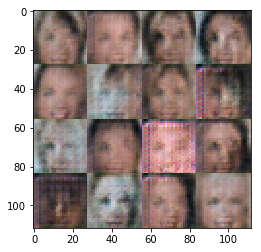

Epoch 1/2..., step 1500 Discriminator Loss: 1.2077... Generator Loss: 1.2285


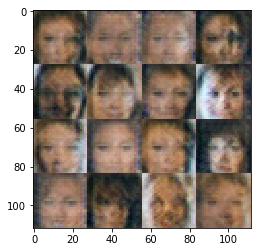

Epoch 1/2..., step 1600 Discriminator Loss: 1.3315... Generator Loss: 0.6794


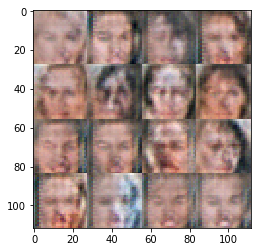

Epoch 1/2..., step 1700 Discriminator Loss: 1.2856... Generator Loss: 0.9542


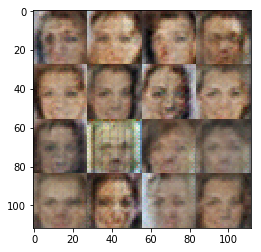

Epoch 1/2..., step 1800 Discriminator Loss: 0.9750... Generator Loss: 1.0085


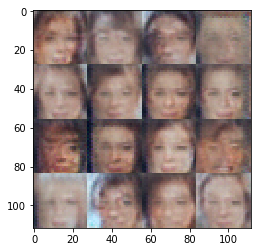

Epoch 1/2..., step 1900 Discriminator Loss: 1.4575... Generator Loss: 0.7632


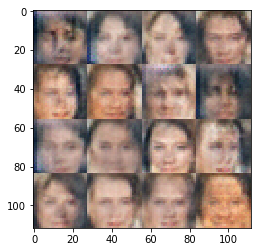

Epoch 1/2..., step 2000 Discriminator Loss: 0.9871... Generator Loss: 1.2711


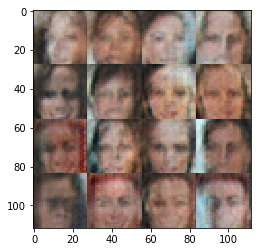

Epoch 1/2..., step 2100 Discriminator Loss: 1.2348... Generator Loss: 1.1279


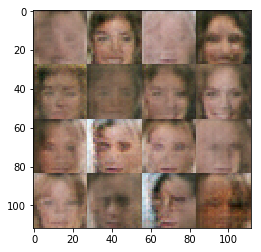

Epoch 1/2..., step 2200 Discriminator Loss: 1.1773... Generator Loss: 0.9368


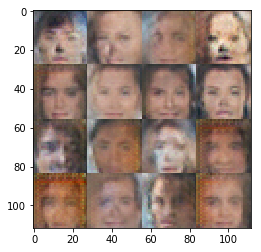

Epoch 1/2..., step 2300 Discriminator Loss: 1.1326... Generator Loss: 1.1089


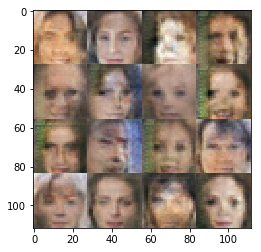

Epoch 1/2..., step 2400 Discriminator Loss: 1.2259... Generator Loss: 0.7977


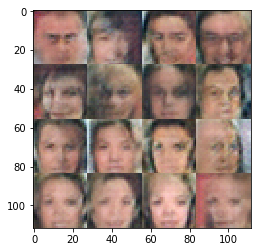

Epoch 1/2..., step 2500 Discriminator Loss: 1.1526... Generator Loss: 0.9398


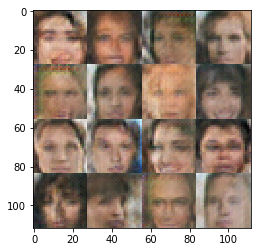

Epoch 1/2..., step 2600 Discriminator Loss: 1.1525... Generator Loss: 0.8096


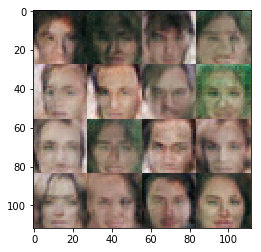

Epoch 1/2..., step 2700 Discriminator Loss: 1.1470... Generator Loss: 0.9420


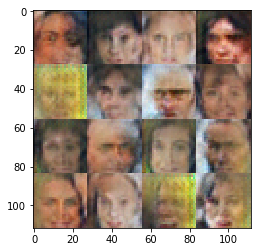

Epoch 1/2..., step 2800 Discriminator Loss: 1.1873... Generator Loss: 0.9342


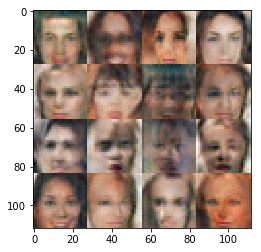

Epoch 1/2..., step 2900 Discriminator Loss: 1.4252... Generator Loss: 0.8782


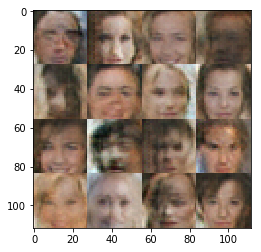

Epoch 1/2..., step 3000 Discriminator Loss: 1.2728... Generator Loss: 1.0043


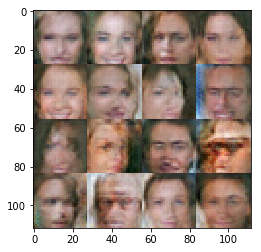

Epoch 1/2..., step 3100 Discriminator Loss: 1.1441... Generator Loss: 0.9901


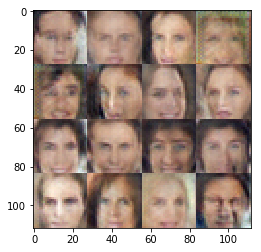

Epoch 2/2..., step 3200 Discriminator Loss: 1.4410... Generator Loss: 0.8124


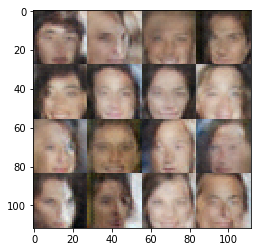

Epoch 2/2..., step 3300 Discriminator Loss: 1.3786... Generator Loss: 1.0698


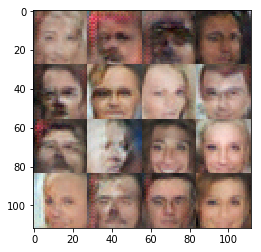

Epoch 2/2..., step 3400 Discriminator Loss: 1.3571... Generator Loss: 0.6668


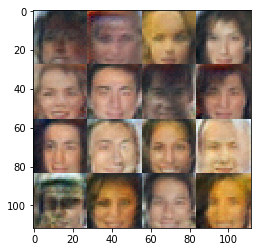

Epoch 2/2..., step 3500 Discriminator Loss: 1.2780... Generator Loss: 0.8292


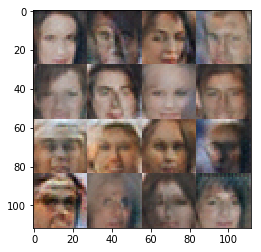

Epoch 2/2..., step 3600 Discriminator Loss: 1.2294... Generator Loss: 1.1845


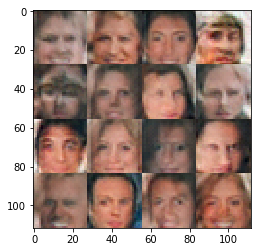

Epoch 2/2..., step 3700 Discriminator Loss: 1.3749... Generator Loss: 0.6481


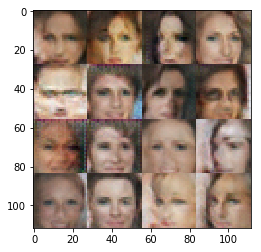

Epoch 2/2..., step 3800 Discriminator Loss: 1.3979... Generator Loss: 0.5621


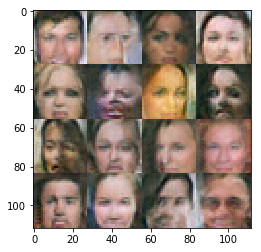

Epoch 2/2..., step 3900 Discriminator Loss: 1.4590... Generator Loss: 0.8935


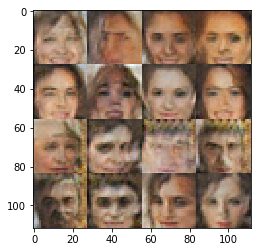

Epoch 2/2..., step 4000 Discriminator Loss: 1.3642... Generator Loss: 0.6727


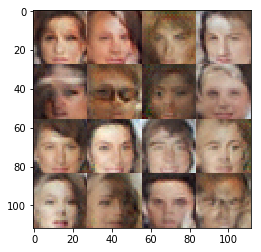

Epoch 2/2..., step 4100 Discriminator Loss: 1.3573... Generator Loss: 0.7162


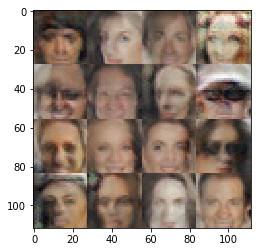

Epoch 2/2..., step 4200 Discriminator Loss: 1.4307... Generator Loss: 0.7485


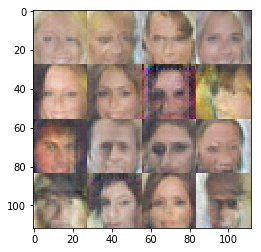

Epoch 2/2..., step 4300 Discriminator Loss: 1.2811... Generator Loss: 0.6205


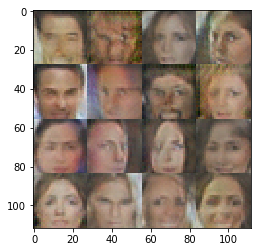

Epoch 2/2..., step 4400 Discriminator Loss: 1.5033... Generator Loss: 0.5025


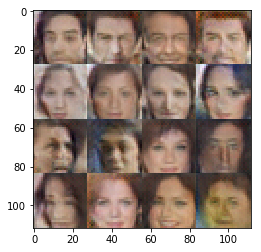

Epoch 2/2..., step 4500 Discriminator Loss: 1.2457... Generator Loss: 0.9541


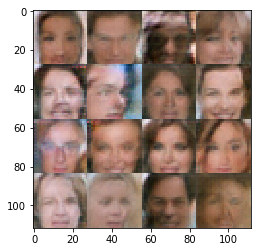

Epoch 2/2..., step 4600 Discriminator Loss: 1.2688... Generator Loss: 0.7536


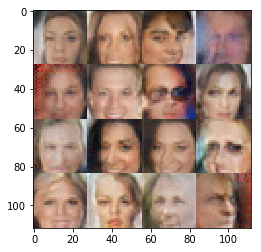

Epoch 2/2..., step 4700 Discriminator Loss: 1.3442... Generator Loss: 0.8616


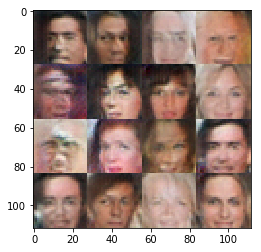

Epoch 2/2..., step 4800 Discriminator Loss: 1.3525... Generator Loss: 0.7475


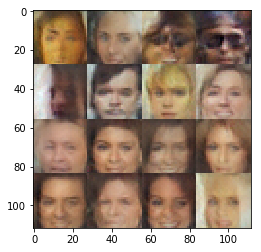

Epoch 2/2..., step 4900 Discriminator Loss: 1.3332... Generator Loss: 0.8861


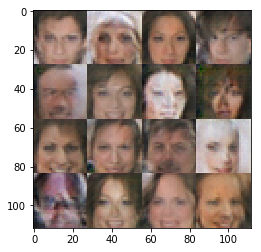

Epoch 2/2..., step 5000 Discriminator Loss: 1.4264... Generator Loss: 0.7992


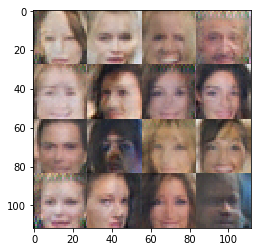

Epoch 2/2..., step 5100 Discriminator Loss: 1.3930... Generator Loss: 0.6888


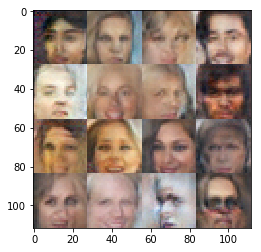

Epoch 2/2..., step 5200 Discriminator Loss: 1.2789... Generator Loss: 0.7493


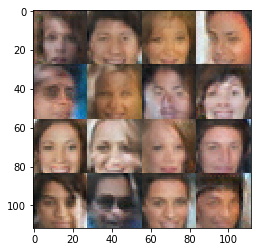

Epoch 2/2..., step 5300 Discriminator Loss: 1.2285... Generator Loss: 0.8247


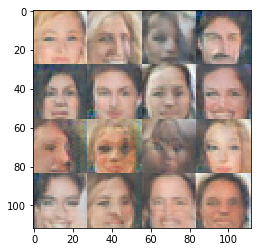

Epoch 2/2..., step 5400 Discriminator Loss: 1.3437... Generator Loss: 0.7451


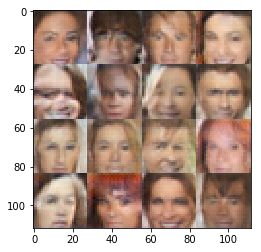

Epoch 2/2..., step 5500 Discriminator Loss: 1.3092... Generator Loss: 0.8291


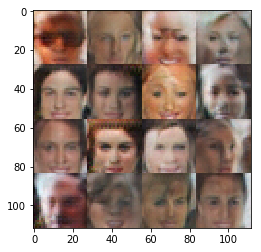

Epoch 2/2..., step 5600 Discriminator Loss: 1.3924... Generator Loss: 0.6162


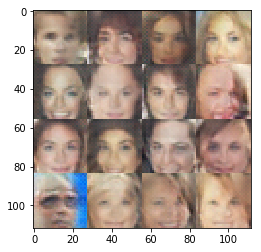

Epoch 2/2..., step 5700 Discriminator Loss: 1.4482... Generator Loss: 0.7383


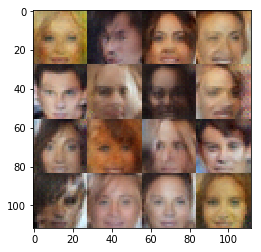

Epoch 2/2..., step 5800 Discriminator Loss: 1.4058... Generator Loss: 0.7263


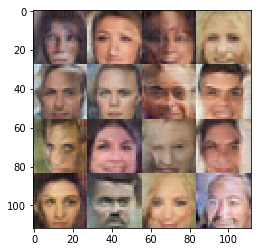

Epoch 2/2..., step 5900 Discriminator Loss: 1.2653... Generator Loss: 0.7821


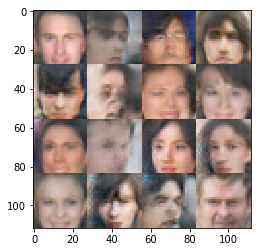

Epoch 2/2..., step 6000 Discriminator Loss: 1.3829... Generator Loss: 0.7465


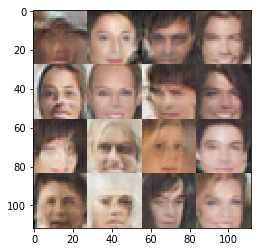

Epoch 2/2..., step 6100 Discriminator Loss: 1.2845... Generator Loss: 0.8295


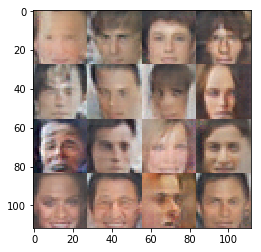

Epoch 2/2..., step 6200 Discriminator Loss: 1.2322... Generator Loss: 0.8717


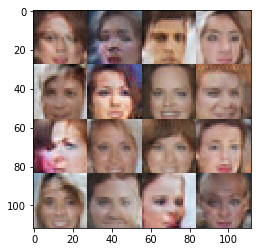

Epoch 2/2..., step 6300 Discriminator Loss: 1.2433... Generator Loss: 0.8710


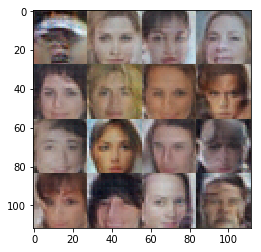

In [77]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.